In [2]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from afqinsight.datasets import AFQDataset
from afqinsight.augmentation import jitter, time_warp, scaling, magnitude_warp, window_warp
import tempfile
from sklearn.impute import SimpleImputer
from neurocombat_sklearn import CombatModel
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.utils import shuffle, resample
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

AUG_SCALING = 1/20



afq_dataset = AFQDataset.from_files(
fn_nodes="../data/raw/combined_tract_profiles.csv",
fn_subjects="../data/raw/participants_updated_id.csv",
dwi_metrics=["dki_fa", "dki_md", "dki_mk"],
index_col="subject_id",
target_cols=["age", "dl_qc_score", "scan_site_id"],
label_encode_cols=["scan_site_id"])
afq_dataset.drop_target_na()
qc = afq_dataset.y[:, 1]
y = afq_dataset.y[:, 0][qc>0]
site = afq_dataset.y[:, 2][qc>0]
X = afq_dataset.X[qc>0]    

In [3]:
afq_dataset = AFQDataset.from_files(
        fn_nodes="../data/raw/combined_tract_profiles.csv",
        fn_subjects="../data/raw/participants_updated_id.csv",
        dwi_metrics=["dki_fa", "dki_md", "dki_mk"],
        index_col="subject_id",
        target_cols=["age", "dl_qc_score", "scan_site_id"],
        label_encode_cols=["scan_site_id"]
    )
afq_dataset.drop_target_na()
full_dataset = list(afq_dataset.as_tensorflow_dataset().as_numpy_iterator())
X = np.concatenate([xx[0][None] for xx in full_dataset], 0)
y = np.array([yy[1][0] for yy in full_dataset])
qc = np.array([yy[1][1] for yy in full_dataset])
site = np.array([yy[1][2] for yy in full_dataset])
X = X[qc>0]
y = y[qc>0]
site = site[qc>0]

2023-09-28 11:19:42.358385: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
X_train, X_test, y_train, y_test, site_train, site_test = train_test_split(X, y, site, test_size=0.2)
imputer = SimpleImputer(strategy="median")

In [5]:
X_train.shape, y_train.shape

((1453, 100, 72), (1453,))

In [6]:
X_train = np.concatenate([imputer.fit_transform(X_train[..., ii])[:, :, None] for ii in range(X_train.shape[-1])], -1)
X_test = np.concatenate([imputer.fit_transform(X_test[..., ii])[:, :, None] for ii in range(X_test.shape[-1])], -1)
# Combat
X_train = np.concatenate([CombatModel().fit_transform(X_train[..., ii], site_train[:, None], None, None)[:, :, None] for ii in range(X_train.shape[-1])], -1)
X_test = np.concatenate([CombatModel().fit_transform(X_test[..., ii], site_test[:, None], None, None)[:, :, None] for ii in range(X_test.shape[-1])], -1)

In [7]:
X_train.shape

(1453, 100, 72)

In [8]:
X_train = np.array([data.flatten() for data in X_train])
X_test = np.array([data.flatten() for data in X_test])

In [9]:
X_train.shape

(1453, 7200)

In [302]:
mlp4 = pd.read_csv('./results_no_aug/mlp4_pca_6_eval.csv')
mlp4[mlp4['Metric']=='mae']['Value'].min()

2.2952921718127075

In [183]:
# Plot MAE for each augmentation
import os

train_size = [1453, 1000, 700, 350, 175, 100]
aug_levels = ['aug1', 'aug2.5', 'aug5', 'aug10', 'aug20', 'aug40']
models = ['lenet', 'mlp4', 'vgg', 'lstm1v0', 'lstm1', 'lstm2', 
          'blstm1', 'blstm2', 'lstmfcn', 'resnet']
filename_list = os.listdir('./results_aug_without_window')
aug_dic = dict()
values = []
for aug_level in aug_levels:
    model_dic = dict()
    for model in models:
        value = 6*[0]
        for file in filename_list:
            char_idx = [i for i in range(len(file)) if file[i] == "_"]
            if model == file[:char_idx[0]] and 'eval.csv' in file and aug_level in file:
                current_df = pd.read_csv('results_aug_without_window/' + file)
                idx = int(file[-10])-1
                value[idx] = current_df[current_df['Metric'] == 'mae']['Value'].min()
        values.append(value)

In [296]:
data_dic = {'aug_level' : 
            np.asarray([[aug_levels[i]]*60 for i in range(len(aug_levels))]).reshape(360,),
            'model': 
            np.asarray([[models[i]]*6 for i in range(len(models))] * 6).reshape(360,),
            'Min MAE': np.asarray(values).reshape(360,)}
df = pd.DataFrame(data_dic)

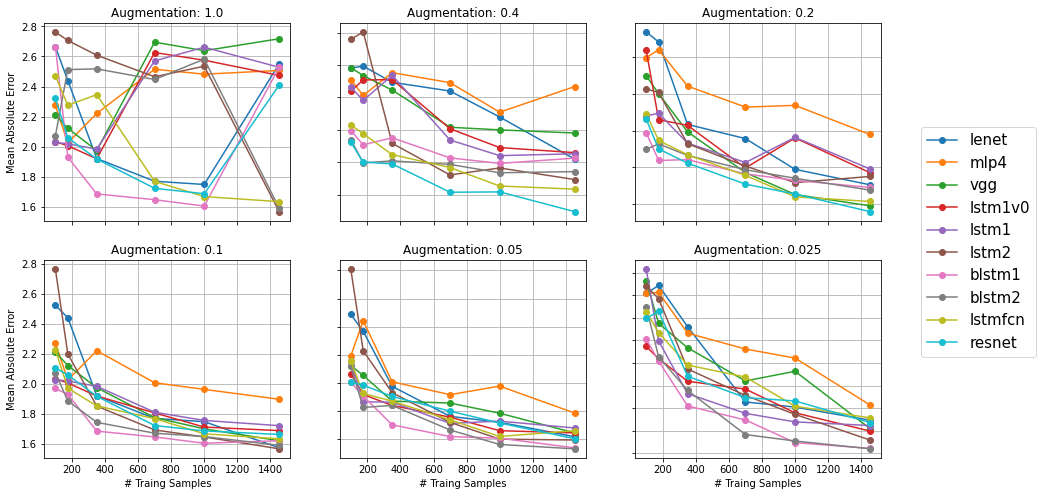

In [292]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 3, figsize=[15,8])
for i in range(len(aug_levels)):
    for j in range(len(models)):
        axs[i//3, i-i//3*3].plot(train_size, df[(df['aug_level']==aug_levels[i]) & (df['model']==models[j])]['Min MAE'], 'o-') 
    axs[i//3, i-i//3*3].set_title('Augmentation: ' + f'{1/float(aug_levels[i][3:])}')
    axs[i//3, i-i//3*3].grid()
for ax in axs.flat:
    ax.set(xlabel='# Traing Samples', ylabel='Mean Absolute Error')
    ax.label_outer()
fig.legend(models, loc='center right', fontsize='15', bbox_to_anchor=(1.05, 0.5))

In [293]:
# aug_levels = ['aug1', 'aug2.5', 'aug5', 'aug10', 'aug20', 'aug40']
# np.asarray([[aug_levels[i]]*6 for i in range(len(aug_levels))]).reshape(1,36)

In [294]:
# np.asarray(values).reshape(360,)

In [41]:
# filename_list = os.listdir('./results_aug_without_window')